In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [7]:
# read in dataset Jill
dset = pd.read_csv('08_09_2016_CC_Subject1.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))

Breath Detection v. 1

In [12]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:14000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/20) # add timestamp assuming 20 samples / second
print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,30)) # smoothen

# calculate [10] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 10*20,center = False).mean() - 15 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp) 

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-5:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-5:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x

d['rbtime'] = d['rbtime'].apply(repNan)
d['fbtime'] = d['fbtime'].apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

   chest  belly    ax   ay    az   gx   gy   gz  time
0   2938   2540  8184  280  4920 -551  337  128  0.00
1   2938   2544  8184  280  4920 -599  481    6  0.05
2   2940   2546  8184  280  4920 -432  479  -58  0.10
3   2943   2549  8182  280  4920 -371  582  -11  0.15
4   2907   2551  8182  280  4920 -353  830  154  0.20


In [13]:
f = d

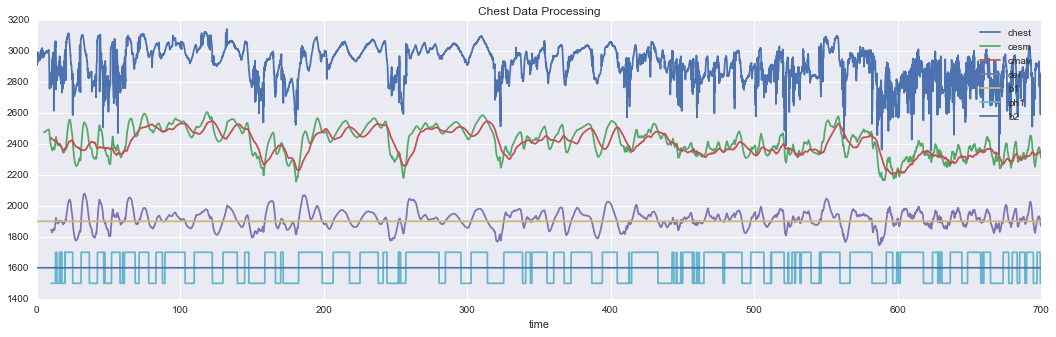

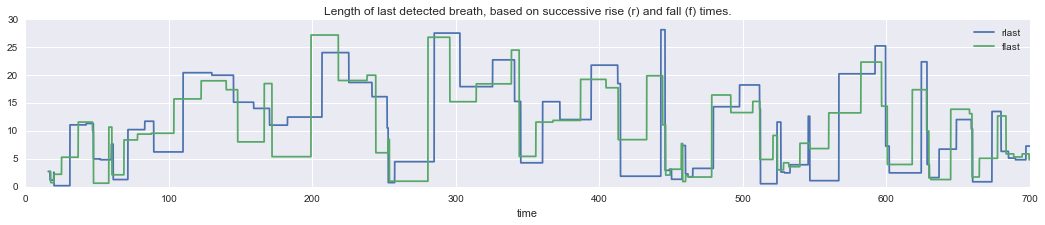

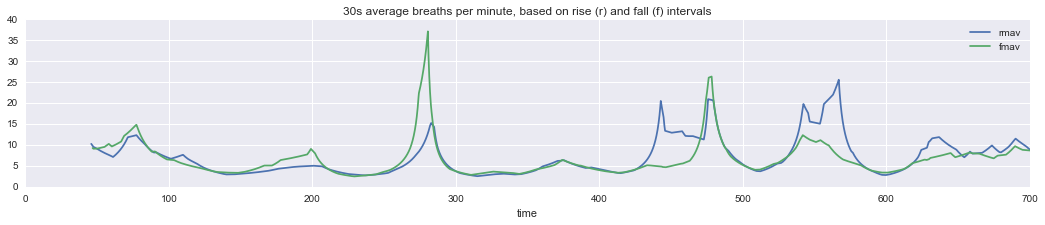

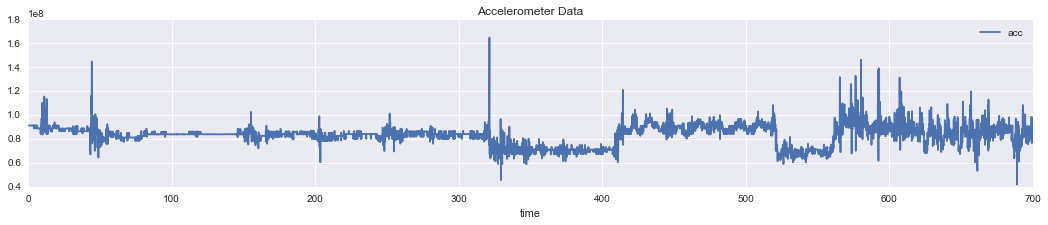

In [14]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 1600
g['b2'] = 1600
g.plot(x = 'time',y = ['chest','cesm','cmav','del','b1','ph1','b2'],figsize = (18,5),title = 'Chest Data Processing')
d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(x = 'time',y = ['rmav','fmav'], figsize = (18,3), title = '30s average breaths per minute, based on rise (r) and fall (f) intervals')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). That is, MovingAverage[X(t_n)] = (1/N)(X(t_n) + X(t_n-1) + ... X(t_n-N)). This is as opposed to a moving average where at each point averaging is performed using the values of the past, the present *and* the future. It is easier to analyze the data when for each data point, the data points that follow in time are already known, but this is obviously not something that can be done in real time. This is something to be kept in mind, however, for situations where it is acceptable that analysis is performed based on data that is a little bit older. For now, everything I coded up is designed to function as close to in real-time as possible. 

Note how differences in the breath length as detected between successive falls and rises are symptomatic of situations where the detection doesn't work well. However, that sort of pattern can be legitimate: a short breath cycle followed by a breath that is held for a long time creates a short time span between successive rises and a very time span between successive falls.

In [15]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly    ax    ay    az    gx    gy    gz   time  ...   \
0          0   2938   2540  8184   280  4920  -551   337   128    0.0  ...    
1000    1000   2606   2552 -4914  1103  7360 -1712   272 -1680   50.0  ...    
2000    2000   3028   2759 -4101    -8  8190  -441   241    56  100.0  ...    
3000    3000   2771   2541 -4373    15  8183  -680    87    -7  150.0  ...    
4000    4000   2967   2562 -4648   280  7644  -240  1468  -160  200.0  ...    
5000    5000   2836   2477 -3269   823  9020  -470  -210 -3463  250.0  ...    
6000    6000   2909   2687 -4644    -9  7912  -374   337   162  300.0  ...    
7000    7000   2962   2681 -7364   -13  3811   -19  -151   164  350.0  ...    
8000    8000   3058   2763 -7096   272  4088  -162   228    70  400.0  ...    
9000    9000   2894   2430  8197     7  4646    66   447    19  450.0  ...    
10000  10000   2899   2282  8467     8  4375  -430   220   288  500.0  ...    
11000  11000   3090   2706 -7364  -553  4086  -689  